以7号车为例，用放电行驶片段计算RDR
- 直接换用平均能耗0.14,3号MAPE，2.48%
- 利用滑动窗口法调整平均能耗，看误差来源

- 目标是MAE大概是5以内，MAEP在4%以内

- 发现只要soh和RDE估算准确，即使是用平均能耗，也能降低到4%误差。进一步的提升空间在能耗的局部修正

In [1]:
from pd_func import *

pd.set_option("display.max_rows()",100)
pd.set_option("display.max_columns()",100)

# 7号车

In [17]:
df_run_V7

,status,c_stat,speed,mileage,t_volt,t_current,soc,max_cell_volt,min_cell_volt,max_temp,min_temp,time,run_frag,charge_frag,power,time_diff,run_energy,cum_run_energy,range,range_diff,cum_mileage,cum_EC
328,1.0,3.0,16.900000,2524.0,328.200012,1.4,59.0,3.286,3.279,26.0,20.0,2018-05-07 10:39:05,1,-1,0.45948,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN
329,1.0,3.0,25.799999,2524.0,327.100006,3.8,59.0,3.277,3.270,26.0,20.0,2018-05-07 10:39:15,1,-1,1.24298,10.0,0.003453,0.003453,0.0,0.0,0.0,0.201381
330,1.0,3.0,29.299999,2524.0,326.799988,14.4,59.0,3.273,3.265,26.0,20.0,2018-05-07 10:39:25,1,-1,4.70592,10.0,0.013072,0.016525,0.0,0.0,0.0,0.206610
331,1.0,3.0,22.299999,2524.0,327.799988,3.2,59.0,3.282,3.276,26.0,20.0,2018-05-07 10:39:35,1,-1,1.04896,10.0,0.002914,0.019438,0.0,0.0,0.0,0.207775
332,1.0,3.0,11.600000,2524.0,327.500000,1.8,59.0,3.279,3.273,26.0,20.0,2018-05-07 10:39:45,1,-1,0.58950,10.0,0.001638,0.021076,0.0,0.0,0.0,0.208430
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7795071,1.0,3.0,0.000000,52079.0,330.299988,9.6,91.0,3.307,3.297,35.0,27.0,2019-08-12 18:44:54,657,-1,3.17088,10.0,0.008808,0.851036,1.0,0.0,1.0,0.184897
7795072,1.0,3.0,1.600000,52079.0,330.299988,9.0,90.0,3.307,3.297,35.0,27.0,2019-08-12 18:45:04,657,-1,2.97270,10.0,0.008257,0.859293,1.0,0.0,1.0,0.185056
7795073,1.0,3.0,2.900000,52079.0,330.500000,5.2,90.0,3.309,3.300,35.0,27.0,2019-08-12 18:45:14,657,-1,1.71860,10.0,0.004774,0.864067,1.0,0.0,1.0,0.185148
7795074,1.0,3.0,0.000000,52079.0,330.700012,2.8,90.0,3.312,3.303,35.0,27.0,2019-08-12 18:45:24,657,-1,0.92596,10.0,0.002572,0.866639,1.0,0.0,1.0,0.185197


In [2]:
df_run_V7=pd.read_pickle("df_run_V7.pickle")
record_run_V7=pd.read_pickle("record_run_V7.pickle")
record_run_V7

,start_time,start_soc,start_mileage,start_t_volt,start_max_temp,start_min_temp,end_time,end_soc,end_mileage,end_t_volt,end_max_temp,end_min_temp,delta_time,delta_soc,delta_mileage,delta_t_volt,delta_max_temp,delta_min_temp
1,2018-05-07T10:39:05.000000000,59.0,2524.0,328.200012,26.0,20.0,2018-05-07T10:50:55.000000000,57.0,2527.0,327.899994,26.0,20.0,0 days 00:11:50,-2.0,3.0,-0.300018,0.0,0.0
2,2018-05-07T14:34:55.000000000,100.0,2527.0,345.0,26.0,20.0,2018-05-08T00:17:56.000000000,43.0,2627.0,327.399994,22.0,16.0,0 days 09:43:01,-57.0,100.0,-17.600006,-4.0,-4.0
3,2018-05-08T05:27:31.000000000,99.0,2627.0,333.899994,23.0,17.0,2018-05-08T10:52:24.000000000,33.0,2748.0,326.600006,24.0,18.0,0 days 05:24:53,-66.0,121.0,-7.299988,1.0,1.0
4,2018-05-08T15:18:03.000000000,87.0,2748.0,334.700012,27.0,21.0,2018-05-08T15:43:51.000000000,85.0,2752.0,332.5,27.0,21.0,0 days 00:25:48,-2.0,4.0,-2.200012,0.0,0.0
5,2018-05-08T16:28:01.000000000,94.0,2752.0,335.100006,27.0,21.0,2018-05-08T23:05:02.000000000,27.0,2873.0,324.899994,26.0,20.0,0 days 06:37:01,-67.0,121.0,-10.200012,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
653,2019-01-13T19:36:55.000000000,99.0,51825.0,334.799988,26.0,10.0,2019-01-13T23:09:26.000000000,32.0,51907.0,326.0,20.0,5.0,0 days 03:32:31,-67.0,82.0,-8.799988,-6.0,-5.0
654,2019-01-14T00:27:51.000000000,95.0,51907.0,334.399994,25.0,8.0,2019-01-14T16:38:33.000000000,26.0,51996.0,329.700012,14.0,1.0,0 days 16:10:42,-69.0,89.0,-4.699982,-11.0,-7.0
655,2019-01-14T17:21:14.000000000,77.0,51996.0,334.200012,21.0,7.0,2019-01-15T06:32:49.000000000,52.0,52027.0,326.5,10.0,-2.0,0 days 13:11:35,-25.0,31.0,-7.700012,-11.0,-9.0
656,2019-01-15T10:33:49.000000000,99.0,52027.0,334.600006,19.0,4.0,2019-03-27T17:07:53.000000000,55.0,52078.0,326.799988,20.0,2.0,71 days 06:34:04,-44.0,51.0,-7.800018,1.0,-2.0


In [3]:
len(record_run_V7[record_run_V7["delta_mileage"]>100])

100

In [5]:
useful_frag=record_run_V7[record_run_V7["delta_mileage"]>100].index.values
run_frag_i=df_run_V7[df_run_V7["run_frag"]==useful_frag[0]]
run_frag_i

,status,c_stat,speed,mileage,t_volt,t_current,soc,max_cell_volt,min_cell_volt,max_temp,min_temp,time,run_frag,charge_frag,power,time_diff,run_energy,cum_run_energy,range,range_diff,cum_mileage,cum_EC
4649,1.0,3.0,9.9,2627.0,333.899994,4.7,99.0,3.421,3.330,23.0,17.0,2018-05-08 05:27:31,3,-1,1.56933,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN
4650,1.0,3.0,5.0,2627.0,333.899994,4.1,99.0,3.414,3.330,23.0,17.0,2018-05-08 05:27:41,3,-1,1.36899,10.0,0.003803,0.003803,0.0,0.0,0.0,0.130757
4651,1.0,3.0,17.1,2627.0,333.600006,1.9,99.0,3.399,3.327,23.0,17.0,2018-05-08 05:27:51,3,-1,0.63384,10.0,0.001761,0.005563,0.0,0.0,0.0,0.130774
4652,1.0,3.0,18.6,2627.0,333.100006,1.5,99.0,3.387,3.324,23.0,17.0,2018-05-08 05:28:01,3,-1,0.49965,10.0,0.001388,0.006951,0.0,0.0,0.0,0.130788
4653,1.0,3.0,23.1,2627.0,332.500000,12.9,99.0,3.375,3.321,23.0,17.0,2018-05-08 05:28:11,3,-1,4.28925,10.0,0.011915,0.018866,0.0,0.0,0.0,0.130907
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,1.0,3.0,0.0,2748.0,326.500000,1.7,33.0,3.268,3.249,24.0,18.0,2018-05-08 10:51:44,3,-1,0.55505,10.0,0.001542,17.208581,121.0,0.0,121.0,0.137016
6502,1.0,3.0,1.9,2748.0,326.500000,1.7,33.0,3.268,3.249,24.0,18.0,2018-05-08 10:51:54,3,-1,0.55505,10.0,0.001542,17.210123,121.0,0.0,121.0,0.137023
6503,1.0,3.0,1.4,2748.0,326.500000,1.7,33.0,3.270,3.249,24.0,18.0,2018-05-08 10:52:04,3,-1,0.55505,10.0,0.001542,17.211665,121.0,0.0,121.0,0.137029
6504,1.0,3.0,0.0,2748.0,326.500000,1.7,33.0,3.270,3.249,24.0,18.0,2018-05-08 10:52:14,3,-1,0.55505,10.0,0.001542,17.213207,121.0,0.0,121.0,0.137036


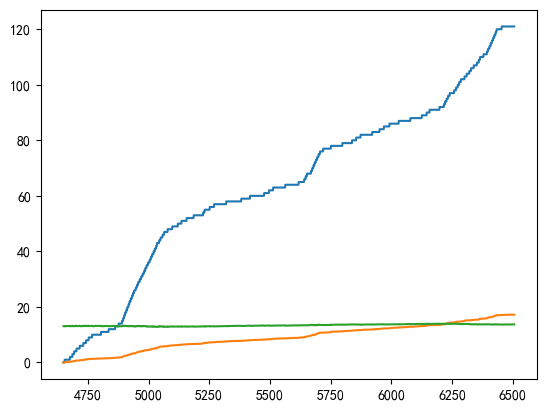

In [6]:
plt.plot(run_frag_i["cum_mileage"])
plt.plot(run_frag_i["cum_run_energy"])
plt.plot(run_frag_i["cum_EC"]*100)

In [7]:
record_charge_df_V7=pd.read_pickle("record_charge_df_V7.pickle")
Q_data=record_charge_df_V7.loc[:,["end_time","end_mileage","moving_ave_Q_max"]]
Q_data["end_time"].values[0]

numpy.datetime64('2018-05-06T13:14:23.000000000')

[26.0996836 26.0996836 26.0996836 ... 26.0996836 26.0996836 26.0996836]


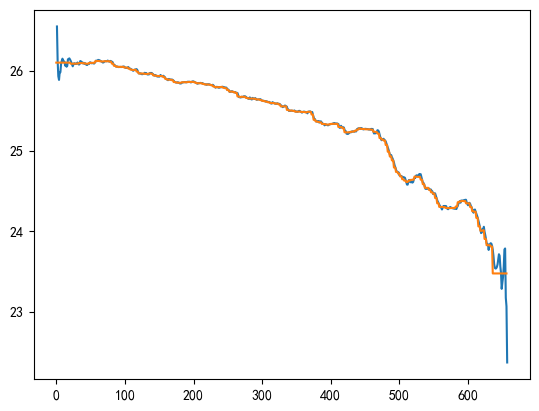

In [9]:
#用LGB拟合一个Q_max的曲线

record_charge_df_V7=pd.read_pickle("record_charge_df_V7.pickle")
Q_data=record_charge_df_V7.loc[:,["end_time","end_mileage","moving_ave_Q_max"]]
Q_data["end_time"]=Q_data["end_time"].astype(np.float64)
Q_data["end_mileage"]=Q_data["end_mileage"].astype(np.float64)
Q_data["moving_ave_Q_max"]=Q_data["moving_ave_Q_max"]*(-1)

import lightgbm as lgb
X=Q_data.loc[:,["end_time","end_mileage"]]
Y=Q_data["moving_ave_Q_max"]
lgb_model = lgb.LGBMRegressor()
lgb_model.fit(X, Y)
Y1=lgb_model.predict(X)
plt.plot(Y)
plt.plot(Y1)

#输入测试数据（一组放电数据），输出一组Q_max
run_frag_i["time"]=run_frag_i["time"].values.astype(np.float64)
x_test=run_frag_i.loc[:,["time","mileage"]]
y_test=lgb_model.predict(x_test)
print(y_test)

In [228]:
run_frag_3

,status,c_stat,speed,mileage,t_volt,t_current,soc,max_cell_volt,min_cell_volt,max_temp,min_temp,time,run_frag,charge_frag,power,time_diff,run_energy,cum_run_energy,range,range_diff,cum_mileage,cum_EC,EC,EC_inter1,EC_inter1_smooth1,cum_EC_smooth1
4649,1.0,3.0,9.9,2627.0,333.899994,4.7,99.0,3.421,3.330,23.0,17.0,2018-05-08 05:27:31,3,-1,1.56933,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,0.044033,0.044033,0.044033,NaN
4650,1.0,3.0,5.0,2627.0,333.899994,4.1,99.0,3.414,3.330,23.0,17.0,2018-05-08 05:27:41,3,-1,1.36899,10.0,0.003803,0.003803,0.0,0.0,0.0,0.130757,0.076055,0.076055,0.043461,0.087177
4651,1.0,3.0,17.1,2627.0,333.600006,1.9,99.0,3.399,3.327,23.0,17.0,2018-05-08 05:27:51,3,-1,0.63384,10.0,0.001761,0.005563,0.0,0.0,0.0,0.130774,0.010296,0.010296,0.037885,0.104645
4652,1.0,3.0,18.6,2627.0,333.100006,1.5,99.0,3.387,3.324,23.0,17.0,2018-05-08 05:28:01,3,-1,0.49965,10.0,0.001388,0.006951,0.0,0.0,0.0,0.130788,0.007462,0.007462,0.058864,0.112116
4653,1.0,3.0,23.1,2627.0,332.500000,12.9,99.0,3.375,3.321,23.0,17.0,2018-05-08 05:28:11,3,-1,4.28925,10.0,0.011915,0.018866,0.0,0.0,0.0,0.130907,0.051578,0.051578,0.052464,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6501,1.0,3.0,0.0,2748.0,326.500000,1.7,33.0,3.268,3.249,24.0,18.0,2018-05-08 10:51:44,3,-1,0.55505,10.0,0.001542,17.208581,121.0,0.0,121.0,0.137016,NaN,0.077612,0.089997,0.137014
6502,1.0,3.0,1.9,2748.0,326.500000,1.7,33.0,3.268,3.249,24.0,18.0,2018-05-08 10:51:54,3,-1,0.55505,10.0,0.001542,17.210123,121.0,0.0,121.0,0.137023,0.081148,0.081148,0.090538,0.137022
6503,1.0,3.0,1.4,2748.0,326.500000,1.7,33.0,3.270,3.249,24.0,18.0,2018-05-08 10:52:04,3,-1,0.55505,10.0,0.001542,17.211665,121.0,0.0,121.0,0.137029,0.110129,0.110129,0.097829,0.137029
6504,1.0,3.0,0.0,2748.0,326.500000,1.7,33.0,3.270,3.249,24.0,18.0,2018-05-08 10:52:14,3,-1,0.55505,10.0,0.001542,17.213207,121.0,0.0,121.0,0.137036,NaN,0.110129,0.110129,0.137036


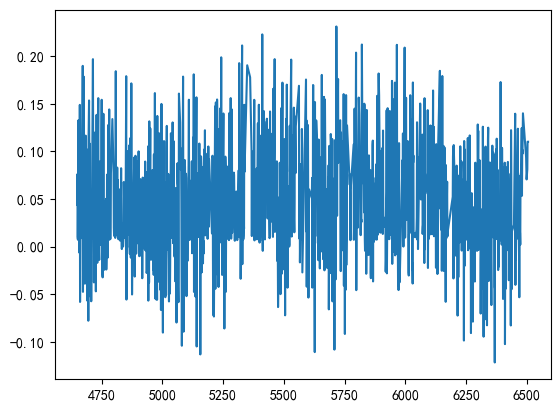

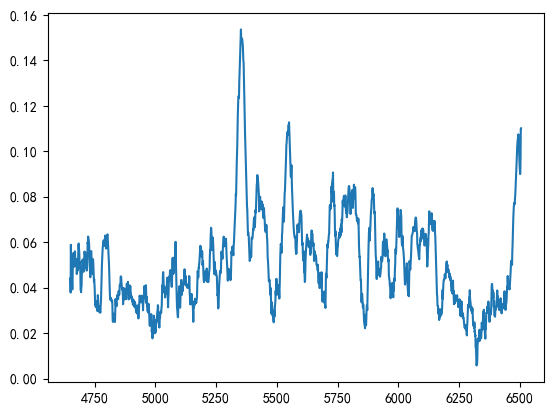

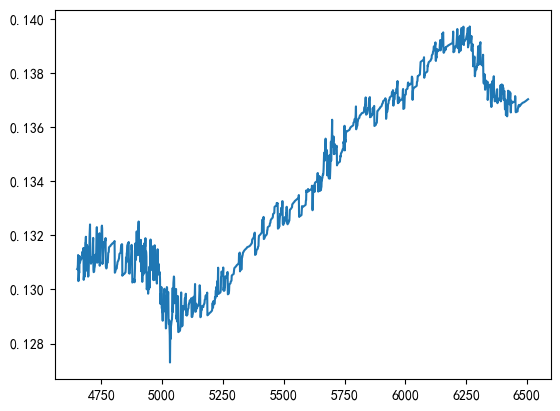

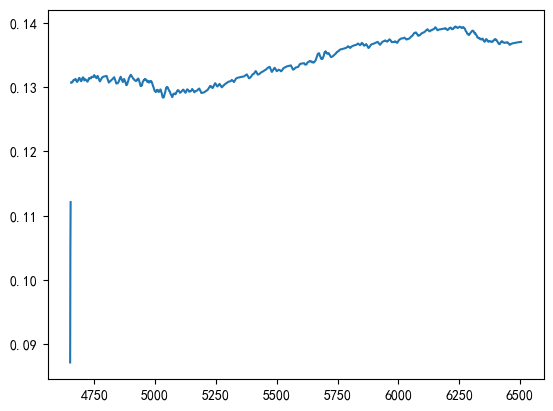

In [238]:
def smooth(a,WSZ):
    # 滑动时间窗函数
    # a:原始数据，NumPy 1-D array containing the data to be smoothed
    # 必须是1-D的，如果不是，请使用 np.ravel()或者np.squeeze()转化
    # WSZ: smoothing window size needs, which must be odd number,

    out0 = np.convolve(a,np.ones(WSZ,dtype=int),"valid")/WSZ
    r = np.arange(1,WSZ-1,2)
    start = np.cumsum(a[:WSZ-1])[::2]/r
    stop = (np.cumsum(a[:-WSZ:-1])[::2]/r)[::-1]
    return np.concatenate(( start , out0, stop ))

#1203 按照速度/功率，得到每一个瞬时的EC,再利用滑动平均法，获得平均能耗
i=3
run_frag_3=df_run_V7[df_run_V7["run_frag"]==i]
run_frag_3["soc"].values[0]
run_frag_3["EC"]=run_frag_3["power"]/run_frag_3["speed"]/3.6
run_frag_3
# plt.figure()
# plt.plot(run_frag_3["EC"])

#能耗值先去掉inf,再插值
run_frag_3["EC"].replace([np.inf, -np.inf], np.nan,inplace=True)
run_frag_3["EC_inter1"]=run_frag_3["EC"].interpolate()
plt.figure()
plt.plot(run_frag_3["EC_inter1"])

#能耗值然后滑动窗口平滑
run_frag_3["EC_inter1_smooth1"]=smooth(run_frag_3["EC_inter1"],WSZ=31)
plt.figure()
plt.plot(run_frag_3["EC_inter1_smooth1"])
##########################这个滑动窗口的效果不好##################

#累积能耗用滑动窗口平滑
plt.figure()
plt.plot(run_frag_3["cum_EC"])

run_frag_3["cum_EC_smooth1"]=smooth(run_frag_3["cum_EC"],WSZ=9)
plt.figure()
plt.plot(run_frag_3["cum_EC_smooth1"])
##########################这个滑动窗口的效果不好##################

In [237]:
i=3
run_frag_3=df_run_V7[df_run_V7["run_frag"]==i]
# run_frag_3["cum_EC_new"]=
run_frag_3.groupby(by="range")["run_energy"].mean()

range
0.0      0.009286
1.0      0.007170
2.0      0.017376
3.0      0.013636
4.0      0.021582
           ...   
117.0    0.045643
118.0    0.026181
119.0    0.031838
120.0    0.004311
121.0    0.002517
Name: run_energy, Length: 122, dtype: float64

In [225]:
def metrics(data):
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_absolute_percentage_error
    out_put_i=data.copy()
    MAE_RDR=out_put_i["RDR"].values
    MAE_RDR_real=out_put_i["RDR-real_range"].values
#     print(MAE_RDR)
#     print(MAE_RDR_real)
    MAE=mean_absolute_error(MAE_RDR,MAE_RDR_real)
    MAPE_RDR=out_put_i["RDR"].values
    MAPE_RDR_real=out_put_i["RDR-real_range"].values
    MAPE=mean_absolute_percentage_error(MAPE_RDR,MAPE_RDR_real)
    return MAE,MAPE

def cal_RDR(i=3,PLOT=False):
    """
    计算RDE
    计算EC
    计算RDR
    """
    out_put_i=pd.DataFrame()
    #计算RDE，读取record_charge_V7的滑动平均Q_max，这是一个时间序列，用于取得对应时间的最大充电能量
    #利用最大充电能量*开始SOC，得到一个放电片段开始的RDE
    run_frag_i=df_run_V7[df_run_V7["run_frag"]==i]
    run_frag_i["time"]=run_frag_i["time"].values.astype(np.float64)
    x_test=run_frag_i.loc[:,["time","mileage"]]
    y_test=lgb_model.predict(x_test)
    out_put_i["Q_max"]=y_test
#     out_put_i["RDE"]=out_put_i["Q_max"].values[0]*run_frag_i["soc"].values[0]/100-run_frag_i["cum_run_energy"].values#这种相对平滑一点
    out_put_i["RDE"]=28*run_frag_i["soc"].values[0]/100-run_frag_i["cum_run_energy"].values#这种相对平滑一点
    #计算平均能耗
    out_put_i["cum_EC"]=run_frag_i["cum_EC"].values
    out_put_i.loc[0,"cum_EC"]=run_frag_i["cum_EC"].values[1]
    #用RDE/EC=RDR
    out_put_i["RDR"]=out_put_i["RDE"]/out_put_i["cum_EC"]
#     out_put_i["RDR"]=out_put_i["RDE"]/0.145
#     out_put_i["RDR"]=out_put_i["RDE"]/run_frag_3["EC_inter1_smooth1"]#按照平滑能耗计算
#     out_put_i["RDR"]=out_put_i["RDE"]/run_frag_3["cum_EC_smooth1"]#按照平滑能耗计算
    
    #真实RDR加上RDR1或者RDR2的最大值减去range
#     #用两段的中间值平凑在一起
#     mid_1=out_put_i["RDR"].median()
#     mid_2=run_frag_i["range"].median()
#     out_put_i["RDR-real_range"]=mid_1+mid_2-run_frag_i["range"].values
    #或者用最大值减去真实值
    max_1=out_put_i["RDR"].max()
    out_put_i["RDR-real_range"]=max_1-run_frag_i["range"].values
#     out_put_i["RDR-real_range"]=run_frag_i["range"].values[-1]-run_frag_i["range"].values+out_put_i["RDR"].values[-1]
    #看看误差值
    MAE,MAPE=metrics(out_put_i)
    #画图看效果
    if PLOT==True:
        plt.figure()
        plt.plot(out_put_i["RDR"],label="RDR")
        plt.plot(out_put_i["RDR-real_range"],label="RDR-real_range")
        plt.legend()
        plt.title("frag_{},MAE_{:.3f},MAPE_{:.3f}".format(i,MAE,MAPE))
        print("i：{},Q_max：{:.2f},MAE：{:.3f},MAPE：{:.3f}".format(i,out_put_i["Q_max"].values[0],MAE,MAPE))
    return out_put_i

i：3,Q_max：26.10,MAE：8.322,MAPE：0.076
i：5,Q_max：26.10,MAE：36.763,MAPE：0.294
i：8,Q_max：26.10,MAE：6.502,MAPE：0.045


,Q_max,RDE,cum_EC,RDR,RDR-real_range
0,26.099684,27.720000,0.132822,208.699817,214.874939
1,26.099684,27.718800,0.132822,208.690785,214.874939
2,26.099684,27.717324,0.132863,208.615254,214.874939
3,26.099684,27.715848,0.132904,208.539815,214.874939
4,26.099684,27.710499,0.133053,208.266737,214.874939
...,...,...,...,...,...
1646,26.099684,12.714597,0.130170,97.677016,98.874939
1647,26.099684,12.712416,0.130184,97.649501,98.874939
1648,26.099684,12.712052,0.130187,97.644913,98.874939
1649,26.099684,12.711598,0.130190,97.639176,98.874939


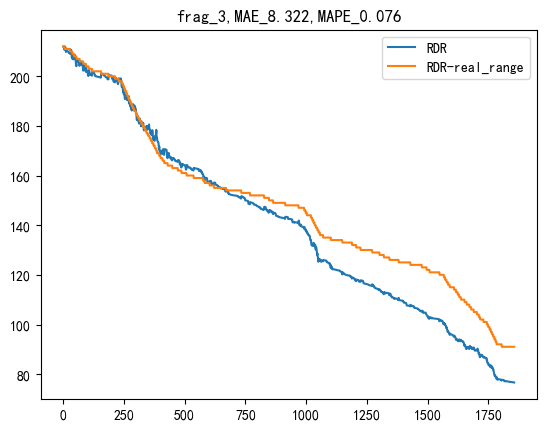

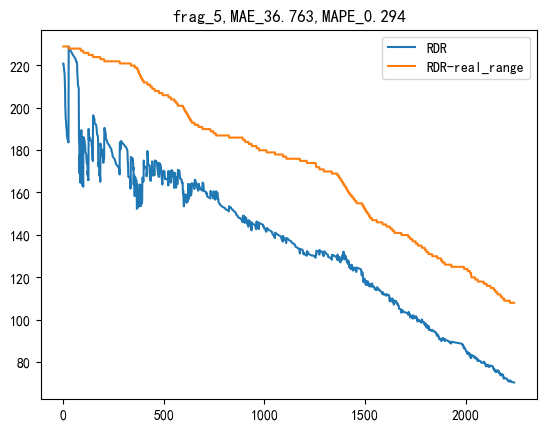

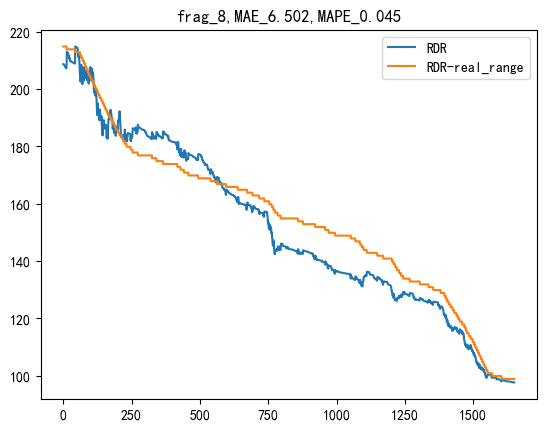

In [226]:
cal_RDR(i=3,PLOT=True)
cal_RDR(i=5,PLOT=True)
cal_RDR(i=8,PLOT=True)

用SOH,累积能耗算
i：3,Q_max：26.10,MAE：7.916,MAPE：0.084
i：5,Q_max：26.10,MAE：34.245,MAPE：0.310
i：8,Q_max：26.10,MAE：6.069,MAPE：0.046

不用SOH,累积能耗算（绝对误差更大，续驶里程值由于RDE估算大了，MAPE相对变小了，这个不太准）
i：3,Q_max：26.10,MAE：8.322,MAPE：0.076
i：5,Q_max：26.10,MAE：36.763,MAPE：0.294
i：8,Q_max：26.10,MAE：6.502,MAPE：0.045

不用SOH,平均能耗算
i：3,Q_max：26.10,MAE：2.585,MAPE：0.020
i：5,Q_max：26.10,MAE：3.047,MAPE：0.031
i：8,Q_max：26.10,MAE：5.679,MAPE：0.046

用SOH,平均能耗算（说明累积能耗还不太准）
i：3,Q_max：26.10,MAE：2.585,MAPE：0.023
i：5,Q_max：26.10,MAE：3.047,MAPE：0.035
i：8,Q_max：26.10,MAE：5.679,MAPE：0.052
确实有点奇怪，为什么MAE没什么变化

In [190]:
i_list=[]
Q_max_list=[]
MAE_list=[]
MAPE_list=[]
for x in useful_frag:
    out_put_i=cal_RDR(i=x)
    MAE,MAPE=metrics(out_put_i)
    i_list.append(x)
    Q_max_list.append(out_put_i["Q_max"].values[0])
    MAE_list.append(MAE)
    MAPE_list.append(MAPE)
record_res=pd.DataFrame()
record_res["i"]=i_list
record_res["Q_max"]=Q_max_list
record_res["MAE"]=MAE_list
record_res["MAPE"]=MAPE_list
#展示记录结果
record_res

,i,Q_max,MAE,MAPE
0,3,26.099684,2.560421,0.024931
1,5,26.099684,2.122300,0.022866
2,8,26.099684,2.874089,0.027298
3,13,26.099684,7.869604,0.093212
4,15,26.099684,3.180909,0.037428
5,18,26.099684,3.848028,0.033767
6,19,26.099684,3.778041,0.042298
7,21,26.099684,4.686076,0.060748
8,22,26.086136,4.237403,0.071477
9,27,26.086136,7.842724,0.084993


i：365,Q_max：25.48,MAE：9.810,MAPE：0.146


,Q_max,RDE,cum_EC,RDR,RDR-real_range
0,25.480695,24.971081,0.158957,172.214350,171.072372
1,25.480695,24.970718,0.158957,172.211846,171.072372
2,25.480695,24.970373,0.158970,172.209471,171.072372
3,25.480695,24.970141,0.158979,172.207866,171.072372
4,25.480695,24.969917,0.158988,172.206326,171.072372
...,...,...,...,...,...
20616,25.480695,8.337655,0.098885,57.501072,-12.927628
20617,25.480695,8.337655,0.098885,57.501072,-12.927628
20618,25.480695,8.337601,0.098886,57.500695,-12.927628
20619,25.480695,8.337555,0.098886,57.500381,-12.927628


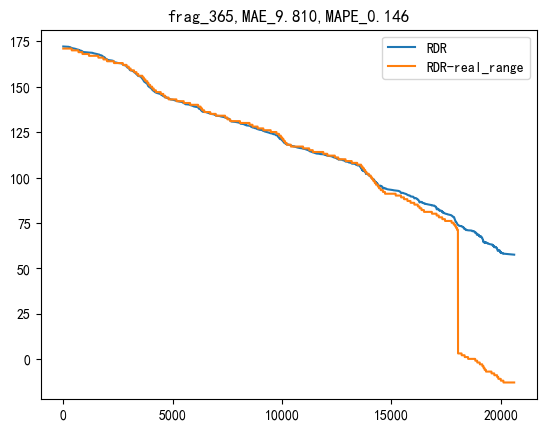

In [193]:
cal_RDR(i=365,PLOT=True)